# Project: Efficient Image Search System

# Color Histogram

### Import stuff

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv 
import os
import glob
from PIL import Image

In [13]:
def get_vector(image, bins=32):
    red = cv2.calcHist([image], [2], None, [bins], [0, 256])
    green = cv2.calcHist([image], [1], None, [bins], [0, 256])
    blue = cv2.calcHist([image], [0], None, [bins], [0, 256])
    vector = np.concatenate([red, green, blue], axis=0)
    vector = vector.reshape(-1)
    return vector

In [3]:
# Define the root directory where your "images" folder is located
root_directory = "dtd-r1.0.1/dtd/images"

# Create a list of all image file extensions you want to consider (e.g., '.jpg', '.png')
image_extensions = ['.jpg', '.png', '.jpeg']

### Create a list that hold 

IMAGE NAME - IMAGE VECTOR

In [4]:
image_data_list = []

In [5]:
for folder_name, subfolders, filenames in os.walk(root_directory):
    for filename in filenames:
        # Check if the file is an image (you can add more image file extensions as needed).
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            # Construct the full path to the image.
            image_path = os.path.join(folder_name, filename)

            # Open the image using PIL.
            image = Image.open(image_path)

            image_array = np.array(image)

            # Apply the get_vector() function to the image.
            processed_image = get_vector(image_array)

            vector_length = processed_image

            image_data_list.append((filename, processed_image))



### Turn it into a csv

In [7]:
# Define the CSV file path to save the data.
csv_file_path = "colored_hist_features.csv"

# Save the image name and vector data to a CSV file.
with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['ImageName', 'Vector'])  # Write header row

    for image_name, vector in image_data_list:
        csv_writer.writerow([image_name, ','.join(map(str, vector))])

### Plot Vector Histogram

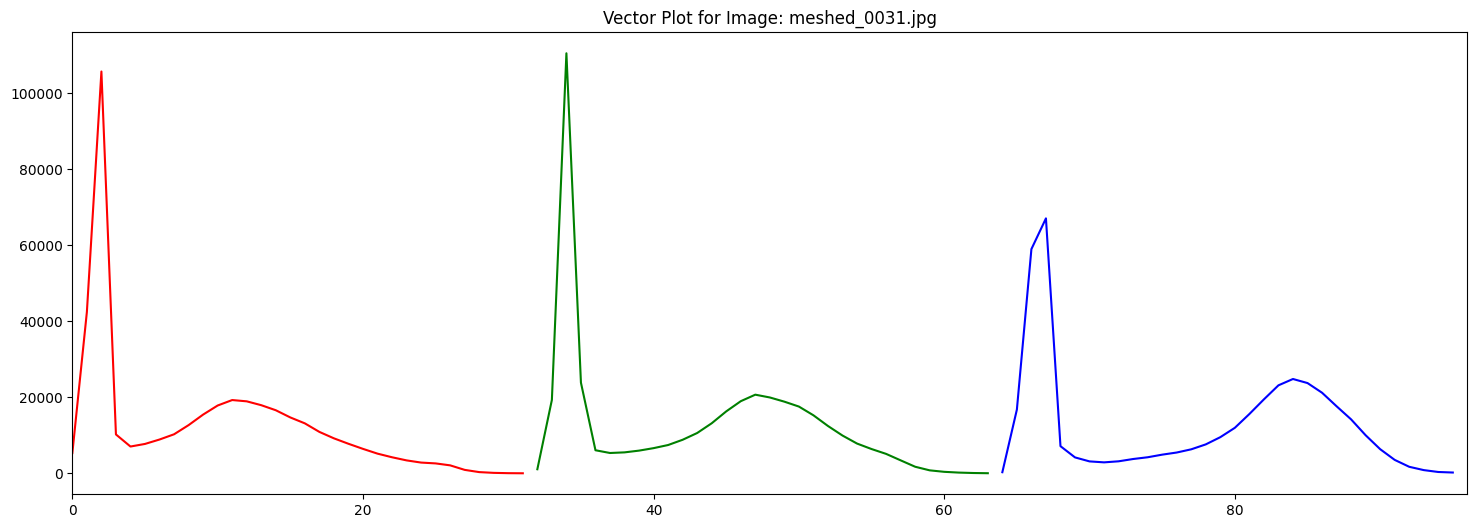

In [8]:
def plot_vector(image_name):

    # Read the CSV file to get the vector for the given image name.
    with open(csv_file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            if row[0] == image_name:
                vector = np.array(list(map(float, row[1].split(','))))
                break

    if vector is None:
        print(f"Image '{image_name}' not found in the CSV file.")
        return



    plt.figure(figsize=(18, 6))
    plt.plot(list(range(32)), vector[:32], color='red')
    plt.plot(list(range(32, 64)), vector[32:64], color='green')
    plt.plot(list(range(64, 96)), vector[64:96], color='blue')
    plt.xlim(0, 96)
    plt.title(f"Vector Plot for Image: {image_name}")
    plt.show()


plot_vector("meshed_0031.jpg")

### Calculate Distance between images 

In [7]:
def euclidean(a, b):
    return np.linalg.norm(a - b)
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [8]:
import csv
import numpy as np
def calculate_distances(image_name1, image_name2, csv_file_path="colored_hist_features.csv"):
    vector1 = None
    vector2 = None
    
    # Read the CSV file to get the vectors for the given image names.
    with open(csv_file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            if row[0] == image_name1:
                vector1 = np.array(list(map(float, row[1].split(','))))
            if row[0] == image_name2:
                vector2 = np.array(list(map(float, row[1].split(','))))

    if vector1 is None or vector2 is None:
        print("One or both of the images were not found in the CSV file.")
        return

    # Calculate Euclidean distance and cosine similarity between the vectors.
    euclidean_distance = euclidean(vector1, vector2)
    cosine_similarity = cosine(vector1, vector2)

    return euclidean_distance, cosine_similarity


val = calculate_distances("banded_0002.jpg","banded_0004.jpg")

print("euclidean Distance:",val[0])
print("Cosine Similarity :",val[1])

euclidean Distance: 205331.95759793458
Cosine Similarity : 0.32835976465585937


### Search

In [11]:
from PIL import Image
# Define a function to search for the most similar images.
def search(query_image_path, csv_file_path, top_k=5):
    # Open the query image using PIL.
    query_image = Image.open(query_image_path)
    query_image_array = np.array(query_image)

    # Apply the get_vector() function to the query image.
    query_vector = get_vector(query_image_array)

    # Read the CSV file to get image vectors.
    image_data_list = []
    with open(csv_file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            image_name = row[0]
            vector = np.array(list(map(float, row[1].split(','))))
            image_data_list.append((image_name, vector))

    # Calculate cosine and Euclidean distances between the query vector and all other vectors.
    cosine_similarities = []
    euclidean_distances = []
    for image_name, vector in image_data_list:
        cosine_similarity = cosine(query_vector, vector)
        euclidean_distance = euclidean(query_vector , vector)
        cosine_similarities.append((image_name, cosine_similarity))
        euclidean_distances.append((image_name, euclidean_distance))

    # Sort the images by similarity/distance in descending order.
    top_cosine_similar_images = sorted(cosine_similarities, key=lambda x: x[1], reverse=True)[:top_k]
    top_euclidean_similar_images = sorted(euclidean_distances, key=lambda x: x[1])[:top_k]

    return top_cosine_similar_images, top_euclidean_similar_images, query_vector



### Top Similarities

In [34]:
import cv2
query_image_path = "dtd-r1.0.1/dtd/images/sprinkled/sprinkled_0012.jpg"
cosine_results, euclidean_results,query_vector  = search(query_image_path, 'colored_hist_features.csv', top_k=5)


print("\nTop 5 Cosine Similar Images:")
for i, (image_name, similarity) in enumerate(cosine_results, 1):
    print(f"Top {i}: {image_name} (Similarity: {similarity:.4f})")

print("\nTop 5 Euclidean Distance Images:")
for i, (image_name, distance) in enumerate(euclidean_results, 1):
    print(f"Top {i}: {image_name} (Euclidean Distance: {distance:.4f})")





Top 5 Cosine Similar Images:
Top 1: sprinkled_0012.jpg (Similarity: 1.0000)
Top 2: sprinkled_0011.jpg (Similarity: 0.9730)
Top 3: knitted_0153.jpg (Similarity: 0.9718)
Top 4: wrinkled_0138.jpg (Similarity: 0.9665)
Top 5: woven_0062.jpg (Similarity: 0.9660)

Top 5 Euclidean Distance Images:
Top 1: sprinkled_0012.jpg (Euclidean Distance: 0.0000)
Top 2: knitted_0153.jpg (Euclidean Distance: 32895.5663)
Top 3: sprinkled_0011.jpg (Euclidean Distance: 37124.0144)
Top 4: meshed_0117.jpg (Euclidean Distance: 40389.8514)
Top 5: meshed_0058.jpg (Euclidean Distance: 42051.2867)


### Visualize

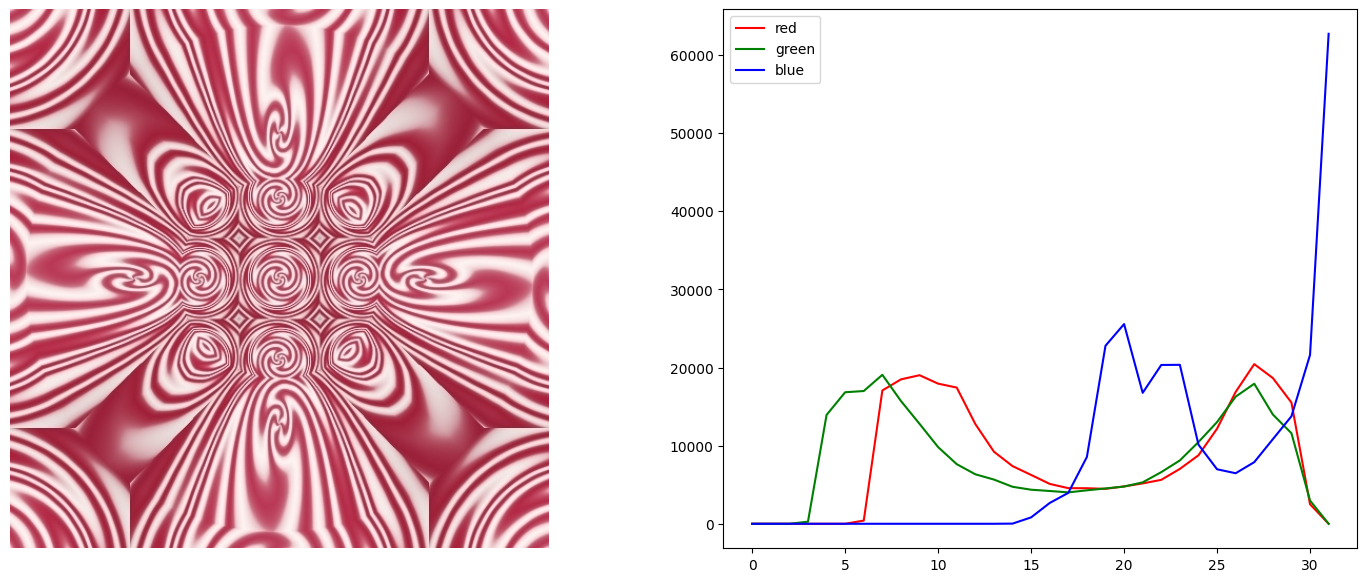

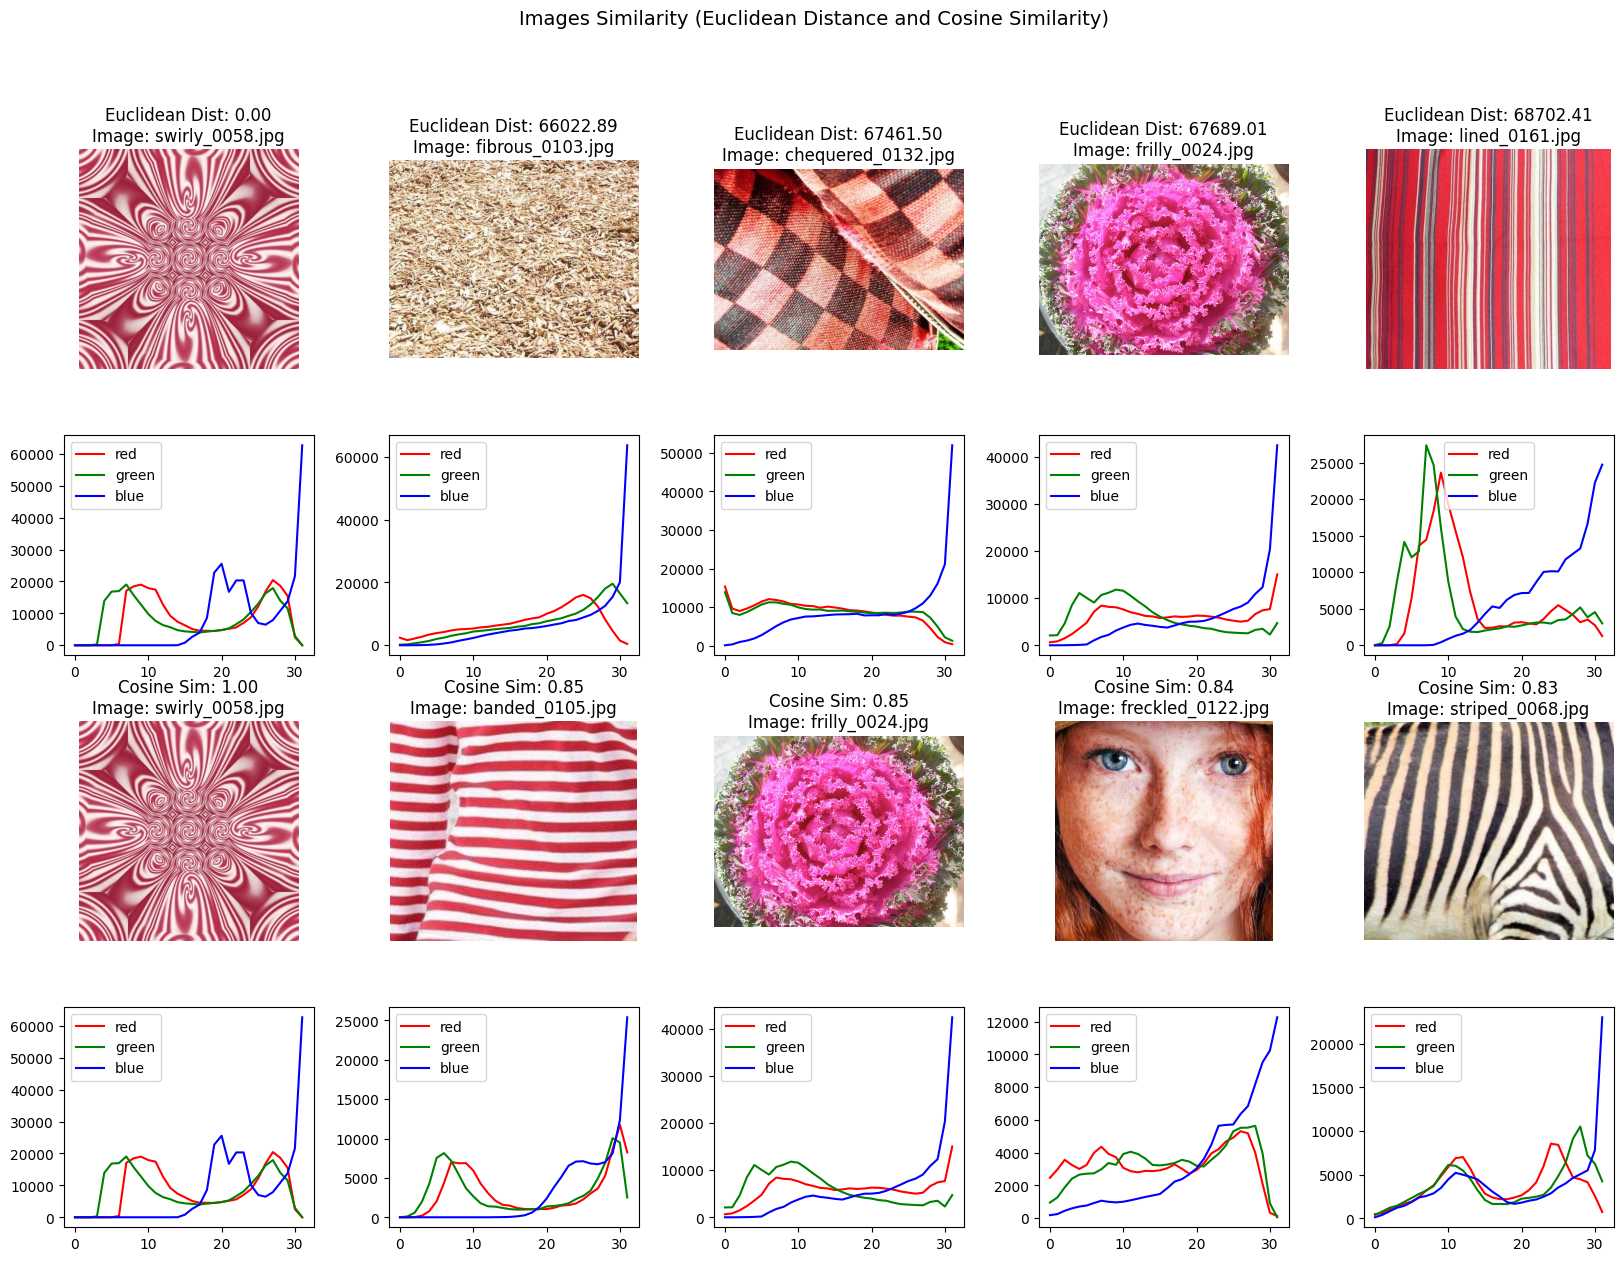

In [32]:
import re
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Regular expression pattern to remove numbers, "jpg", and underscores
pattern = r'\d+|\.jpg|_'

# Define the visualize function with the requested inputs.
def visualize(query_image_path, query_vector, euclidean_results, cosine_results):
    top_k = 5
    span = 32
    csv_file_path = "colored_hist_features.csv"

    # Load the query image using PIL.
    query_image = Image.open(query_image_path)
    query_image_array = np.array(query_image)

    # Visualize the query image and its color histogram
    fig, axs = plt.subplots(1, 2, figsize=(18, 7))
    axs[0].imshow(query_image_array)
    axs[0].axis('off')
    axs[1].plot(query_vector[:span], 'r', label='red')
    axs[1].plot(query_vector[span:span * 2], 'g', label='green')
    axs[1].plot(query_vector[span * 2:], 'b', label='blue')
    axs[1].legend(['red', 'green', 'blue'])

    plt.show()

    fig, axes = plt.subplots(4, top_k, figsize=(top_k * 4, 14))  # Increase the figure size

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    fig.suptitle('Images Similarity (Euclidean Distance and Cosine Similarity)', fontsize=14)

    for i in range(top_k):
        # Plot the closest images based on Euclidean distance.
        image_name, distance = euclidean_results[i]
        # Clean the image_name to remove numbers, "jpg," and underscores
        cleaned_file_path = re.sub(pattern, '', image_name)
        image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'

        with open(csv_file_path, 'r', newline='') as csvfile:
            csv_reader = csv.reader(csvfile)
            next(csv_reader)  # Skip the header row
            for row in csv_reader:
                if row[0] == image_name:
                    vector1 = np.array(list(map(float, row[1].split(','))))
                    image = Image.open(image_path)
                    axes[0, i].imshow(image)
                    axes[0, i].set_title(f'Euclidean Dist: {distance:.2f}\nImage: {image_name}')
                    axes[0, i].axis('off')

                    axes[1, i].plot(vector1[:span], 'r', label='red')
                    axes[1, i].plot(vector1[span:span * 2], 'g', label='green')
                    axes[1, i].plot(vector1[span * 2:], 'b', label='blue')
                    axes[1, i].legend(['red', 'green', 'blue'])

            # Plot the closest images based on Cosine similarity.
            image_name, similarity = cosine_results[i]
            # Clean the image_name to remove numbers, "jpg," and underscores
            cleaned_file_path = re.sub(pattern, '', image_name)
            image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'

            with open(csv_file_path, 'r', newline='') as csvfile:
                csv_reader = csv.reader(csvfile)
                next(csv_reader)  # Skip the header row
                for row in csv_reader:
                    if row[0] == image_name:
                        vector1 = np.array(list(map(float, row[1].split(','))))
                        image = Image.open(image_path)
                        axes[2, i].imshow(image)
                        axes[2, i].set_title(f'Cosine Sim: {similarity:.2f}\nImage: {image_name}')
                        axes[2, i].axis('off')

                        axes[3, i].plot(vector1[:span], 'r', label='red')
                        axes[3, i].plot(vector1[span:span * 2], 'g', label='green')
                        axes[3, i].plot(vector1[span * 2:], 'b', label='blue')
                        axes[3, i].legend(['red', 'green', 'blue'])

    plt.show()

# Example usage:
visualize(query_image_path, query_vector, euclidean_results, cosine_results)


In [79]:
import csv
import time
import re

import csv
import time
import re

pattern = r'\d+|\.jpg|_'

def calculate_precision_at_k(true_image, top_k_results):
    pattern = r'\d+|\.jpg|_'
    total = 0

    for result in top_k_results:
        filename, _ = result
        filename = re.sub(pattern, '', filename)
        if filename == true_image:
            print("true")
            # print(true_image)
            # print(filename)
            total += 1
            
            
        else:
            print("false")
            # print(true_image)
            # print(filename)
        
        return total
    

def calculate_precision_at_1(true_image, top_k_results):
    pattern = r'\d+|\.jpg|_'

    if top_k_results:
        filename, _ = top_k_results[0]
        filename = re.sub(pattern, '', filename)
        if filename == true_image:
            return 1.0
        else:
            return 0.0



    

def calculate_average_precision_at_k(csv_file_path, top_k):
    with open(csv_file_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        total_precision_at_k = 0
        total_retrieval_time = 0
        total_precision_at_1 = 0
        total_images = 0
        top_k = 10

        for row in csv_reader:
            image_name, _ = row[0], row[1]
            cleaned_file_path = re.sub(pattern, '', image_name)
            print(image_name)
            image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'
            query_image_path = image_path
            #print(query_image_path)
            start_time = time.time()
            top_cosine_similar_images, _, _ = search(query_image_path, csv_file_path, top_k)
            retrieval_time = time.time() - start_time
            precision_at_k = calculate_precision_at_k(cleaned_file_path, top_cosine_similar_images)
            precision_at_1 = calculate_precision_at_1(cleaned_file_path, top_cosine_similar_images)

            total_precision_at_k += precision_at_k
            total_retrieval_time += retrieval_time
            total_precision_at_1 += precision_at_1
            total_images += 1

    average_precision_at_k = total_precision_at_k / total_images
    average_retrieval_time = total_retrieval_time / total_images
    average_1 = total_precision_at_1/ total_images
    print("total_images: ", total_images)
    print("total_precision_at_k: ", total_precision_at_k)
    print("total_retrieval_time: ",total_retrieval_time)

    return average_precision_at_k, average_retrieval_time, average_1

csv_file_path = 'colored_hist_features.csv'
top_k = 10  # You can change this value as needed

average_precision_at_10, average_retrieval_time, total_precision_at_1 = calculate_average_precision_at_k(csv_file_path, top_k)

print(f'Average Precision at {top_k}: {average_precision_at_10}')
print(f'Average Retrieval Time: {average_retrieval_time} seconds')
print(f'Average Precision at 1: {total_precision_at_1}')


banded_0002.jpg
true
banded_0004.jpg
true
banded_0005.jpg
true
banded_0006.jpg
true
banded_0008.jpg
true
banded_0009.jpg
true
banded_0010.jpg
true
banded_0011.jpg
true
banded_0012.jpg
true
banded_0013.jpg
true
banded_0016.jpg
true
banded_0019.jpg
true
banded_0021.jpg
true
banded_0022.jpg
true
banded_0023.jpg
true
banded_0024.jpg
true
banded_0025.jpg
true
banded_0030.jpg
true
banded_0033.jpg
true
banded_0034.jpg
true
banded_0036.jpg
true
banded_0037.jpg
true
banded_0039.jpg
true
banded_0041.jpg
true
banded_0042.jpg
true
banded_0043.jpg
true
banded_0044.jpg
true
banded_0045.jpg
true
banded_0046.jpg
true
banded_0047.jpg
true
banded_0049.jpg
true
banded_0051.jpg
true
banded_0053.jpg
true
banded_0055.jpg
true
banded_0057.jpg
true
banded_0058.jpg
true
banded_0059.jpg
true
banded_0060.jpg
true
banded_0061.jpg
true
banded_0062.jpg
true
banded_0063.jpg
true
banded_0064.jpg
true
banded_0066.jpg
true
banded_0067.jpg
true
banded_0068.jpg
true
banded_0069.jpg
true
banded_0072.jpg
true
banded_0073.j

true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true


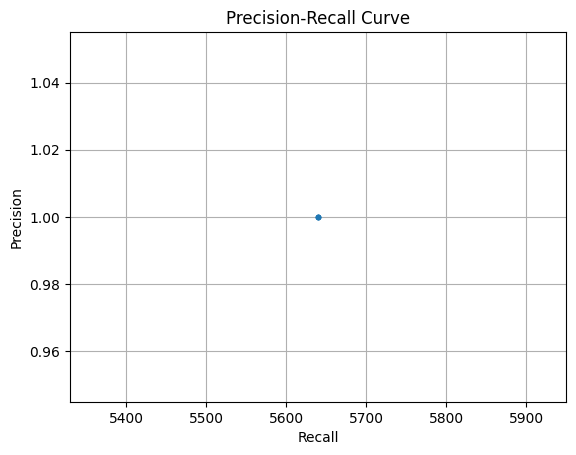

In [82]:
import csv
import time
import re
import numpy as np
import matplotlib.pyplot as plt

# Define the pattern and functions for precision calculation as shown in your code

def calculate_precision_recall_curve(csv_file_path, thresholds, precisions, recalls):
    for threshold in thresholds:
        with open(csv_file_path, 'r') as csvfile:
            csv_reader = csv.reader(csvfile)
            next(csv_reader)  # Skip the header row
            total_precision_at_k = 0
            total_images = 0

            for row in csv_reader:
                image_name, _ = row[0], row[1]
                cleaned_file_path = re.sub(pattern, '', image_name)
                image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'
                query_image_path = image_path
                top_cosine_similar_images, _, _ = search(query_image_path, csv_file_path, top_k)
                precision_at_k = calculate_precision_at_k(cleaned_file_path, top_cosine_similar_images)
                total_precision_at_k += precision_at_k
                total_images += 1

        average_precision_at_k = total_precision_at_k / total_images
        precisions.append(average_precision_at_k)
        recalls.append(total_images)

    return precisions, recalls

# Function to plot the Precision-Recall curve
def plot_precision_recall_curve(precisions, recalls):
    plt.plot(recalls, precisions, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.show()

# Define your CSV file path, thresholds, precisions, and recalls
csv_file_path = 'colored_hist_features.csv'
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]  # Define the thresholds you want to use
precisions = []
recalls = []

precisions, recalls = calculate_precision_recall_curve(csv_file_path, thresholds, precisions, recalls)
plot_precision_recall_curve(precisions, recalls)
